In [1]:
import os
import keras
keras.__version__

Using TensorFlow backend.


'2.1.0'

In [2]:
train_image_dir = 'train/image'
train_label_dir = 'train/image'
val_image_dir = 'val/image'
val_label_dir = 'val/image'

In [3]:
print('total training images:', len(os.listdir(train_image_dir)))
print('total training labels:', len(os.listdir(train_label_dir)))
print('total validation images:', len(os.listdir(val_image_dir)))
print('total validation labels:', len(os.listdir(val_label_dir)))

total training images: 234
total training labels: 234
total validation images: 26
total validation labels: 26


In [4]:
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

In [5]:
seed = 1
batch_size= 4

image_datagen = ImageDataGenerator(rescale=1./255)
mask_datagen  = ImageDataGenerator()

image_generator = image_datagen.flow_from_directory(
        './train/',
        classes = ['image'],
        target_size=(256, 256),
        color_mode="grayscale",
        batch_size=batch_size,
        seed=seed,
        class_mode=None)

mask_generator = mask_datagen.flow_from_directory(
    './train/',
    classes = ['label'],
    target_size=(256, 256),
    color_mode="grayscale",
    batch_size=batch_size,
    seed=seed,                      # 注意必须用seed,否则image和mask不匹配
    class_mode=None)

val_image_generator = image_datagen.flow_from_directory(
        './val/',
        classes = ['image'],
        target_size=(256, 256),
        color_mode="grayscale",
        batch_size=batch_size,
        seed=seed,
        class_mode=None)

val_mask_generator = mask_datagen.flow_from_directory(
    './val/',
    classes = ['label'],
    target_size=(256,256),
    color_mode="grayscale",
    batch_size=batch_size,
    seed=seed,
    class_mode=None)

train_generator = zip(image_generator, mask_generator)
validation_generator = zip(val_image_generator, val_mask_generator)

Found 234 images belonging to 1 classes.
Found 234 images belonging to 1 classes.
Found 26 images belonging to 1 classes.
Found 26 images belonging to 1 classes.


In [6]:
import matplotlib.pyplot as plt
import numpy as np

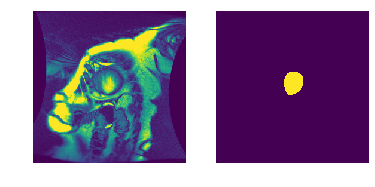

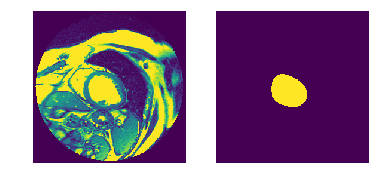

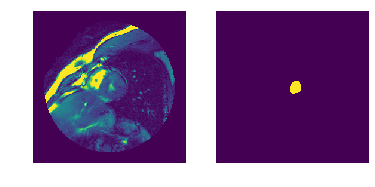

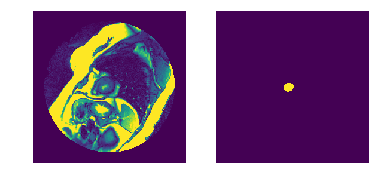

In [7]:
img = image_generator.next()
msk = mask_generator.next()

for i in range(batch_size):
    fig, axes = plt.subplots(1, 2)
    axes[0].set_axis_off()
    axes[0].imshow(img[i].reshape(img[0].shape[:-1]))
    axes[1].set_axis_off()
    axes[1].imshow(msk[i].reshape(img[0].shape[:-1]))
plt.show()

In [8]:
from keras import layers
from keras import models

def MLP():
    # MLP 2分类
    model = models.Sequential()
    model.add(layers.Flatten(input_shape=(256,256,1)))
    model.add(layers.Dense(100, activation='relu'))
    model.add(layers.Dense(100, activation='relu'))
    model.add(layers.Dense(256*256, activation='sigmoid'))
    model.add(layers.Reshape((256, 256,1)))
    return model

In [9]:
from keras import backend as K

def mIoU(y_true,y_pred):
    inter = K.sum(y_true*y_pred)
    union = K.sum(y_true+y_pred-y_pred*y_true)
    return inter/union

In [10]:
model = MLP()
model.summary()
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy',mIoU])
history = model.fit_generator(
      train_generator,
      steps_per_epoch=234//batch_size+1,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=26//batch_size+1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 65536)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               6553700   
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 65536)             6619136   
_________________________________________________________________
reshape_1 (Reshape)          (None, 256, 256, 1)       0         
Total params: 13,182,936
Trainable params: 13,182,936
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
59/59 [==============================] - 7s 111ms/step - loss: 0.0470 - acc: 0.9780 - mIoU: 0.3060 - val_loss: 0.0247 

4/4 [==============================] - 2s 435ms/step


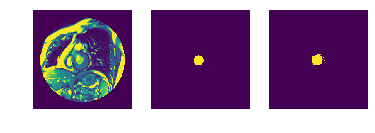

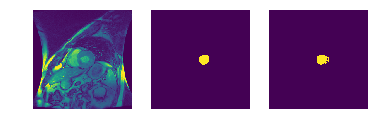

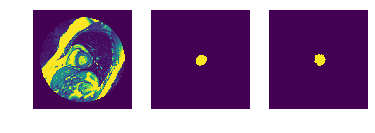

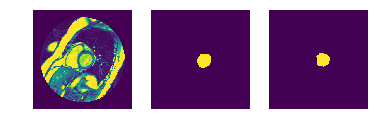

In [11]:
img = val_image_generator.next()
msk = val_mask_generator.next()
pre = model.predict_classes(img)
for i in range(batch_size):
    fig, axes = plt.subplots(1, 3)
    axes[0].set_axis_off()
    axes[0].imshow(img[i].reshape(img[0].shape[:-1]))
    axes[1].set_axis_off()
    axes[1].imshow(msk[i].reshape(img[0].shape[:-1]))
    axes[2].set_axis_off()
    axes[2].imshow(pre[i].reshape(img[0].shape[:-1]))
plt.show()

In [12]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'val_mIoU', 'val_loss', 'acc', 'val_acc', 'mIoU'])

In [16]:
import matplotlib.pyplot as plt

def loss_plot(history):
    plt.clf()
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()
    
def accuracy_plot(history):
    plt.clf()
    
    acc_values = history.history['acc']
    val_acc_values = history.history['val_acc']
    epochs = range(1, len(acc_values) + 1)
    
    plt.plot(epochs, acc_values, 'bo', label='Training acc')
    plt.plot(epochs, val_acc_values, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()
    
def miou_plot(history):
    plt.clf()
    
    iou_values = history.history['mIoU']
    val_iou_values = history.history['val_mIoU']
    epochs = range(1, len(iou_values) + 1)
    
    plt.plot(epochs, iou_values, 'bo', label='Training iou')
    plt.plot(epochs, val_iou_values, 'b', label='Validation iou')
    plt.title('Training and validation mIoU')
    plt.xlabel('Epochs')
    plt.ylabel('mIoU')
    plt.legend()

    plt.show()

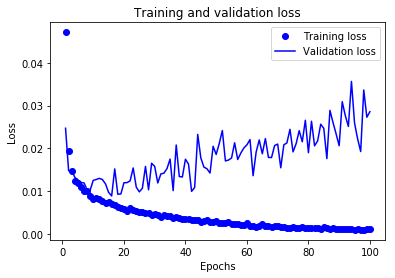

In [14]:
loss_plot(history)

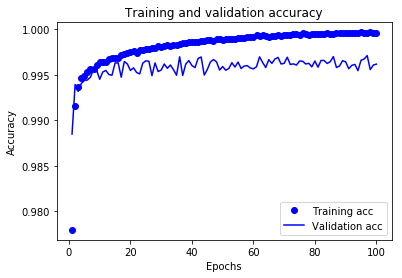

In [17]:
accuracy_plot(history)

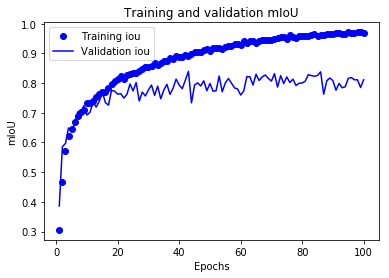

In [18]:
miou_plot(history)

In [19]:
from keras import backend as K
K.clear_session()

In [20]:
 def FCN():
    model = models.Sequential()
    model.add(layers.Conv2D(64,5,activation='relu',strides=2,padding='same',input_shape=(256, 256, 1)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128,5,activation='relu',strides=2,padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128,3,activation='relu',padding='same'))
    model.add(layers.Conv2D(128,3,activation='relu',padding='same'))
    model.add(layers.Conv2D(128,1,activation='relu',padding='same'))
    model.add(layers.Deconvolution2D(1,kernel_size=32,strides=16,padding='same', activation='sigmoid'))
    return model

In [21]:
model = FCN()
model.summary()
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy',mIoU])
history = model.fit_generator(
      train_generator,
      steps_per_epoch=234//batch_size+1,
      epochs=150,
      validation_data=validation_generator,
      validation_steps=26//batch_size+1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 128, 128, 64)      1664      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 128)       204928    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 128)       147584    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 128)       147584    
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 16, 16, 128)       16512     
__________

4/4 [==============================] - 1s 222ms/step


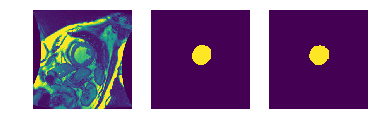

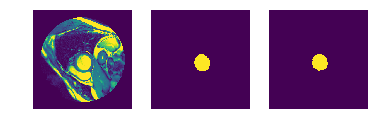

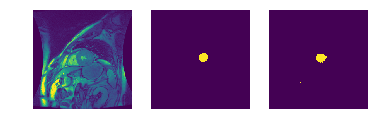

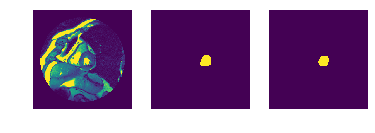

In [22]:
img = val_image_generator.next()
msk = val_mask_generator.next()
pre = model.predict_classes(img)
for i in range(batch_size):
    fig, axes = plt.subplots(1, 3)
    axes[0].set_axis_off()
    axes[0].imshow(img[i].reshape(img[0].shape[:-1]))
    axes[1].set_axis_off()
    axes[1].imshow(msk[i].reshape(img[0].shape[:-1]))
    axes[2].set_axis_off()
    axes[2].imshow(pre[i].reshape(img[0].shape[:-1]))
plt.show()

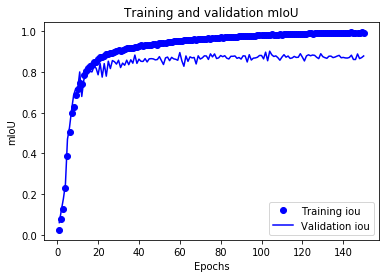

In [23]:
miou_plot(history)